/home/dai/GPU-Student-2/Cederic/anaconda3/envs/diffcounter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Created directory: /home/dai/GPU-Student-2/Cederic/DataSciPro/data_output/folder_IMG_27112
Created directory: /home/dai/GPU-Student-2/Cederic/DataSciPro/data_output/folder_IMG_27931


/home/dai/GPU-Student-2/Cederic/anaconda3/envs/diffcounter/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/dai/GPU-Student-2/Cederic/anaconda3/envs/diffcounter/lib/python3.10/site-packages/diffusers/configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
The config attributes {'timestep_values': None, 'timesteps': 1000} were passed to DDIMScheduler, but are 

tensor(-2.3061, device='cuda:0')
tensor(-2.1493, device='cuda:0')
tensor([False, False])


/home/dai/GPU-Student-2/Cederic/anaconda3/envs/diffcounter/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 0/2 [00:00<?, ?it/s]/home/dai/GPU-Student-2/Cederic/anaconda3/envs/diffcounter/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
100%|██████████| 129/129 [00:03<00:00, 39.

Classifier prediction: -2.318805694580078
0 loss: 2.412652015686035 lr: [0.01]
Classifier prediction: -1.6173276901245117
2 loss: 1.7983386516571045 lr: [0.009931100837462445]
Classifier prediction: -0.562715470790863
4 loss: 1.0135746002197266 lr: [0.009774869058090914]
Classifier prediction: 0.19000577926635742
6 loss: 0.6026502847671509 lr: [0.009543642776065642]
Diffusion Counterfactual generated with loss: 0.6026502847671509 | classifier_prediction: 0.19000577926635742 | in 7 optimization steps


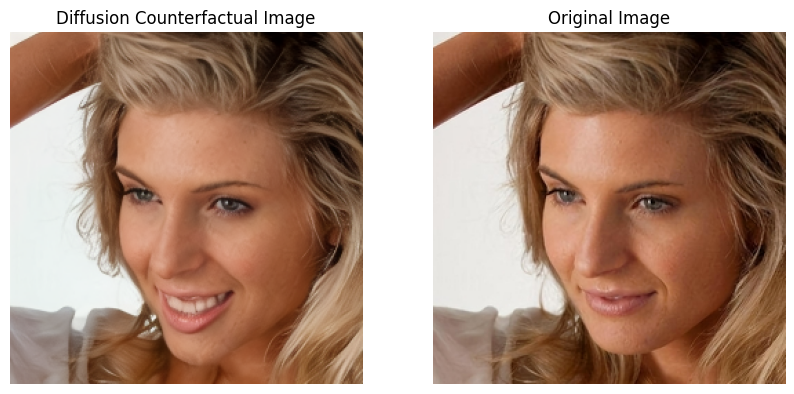

 50%|█████     | 1/2 [00:20<00:20, 20.13s/it]

finish


100%|██████████| 129/129 [00:03<00:00, 34.46it/s]


Classifier prediction: -2.1953492164611816
0 loss: 2.3008973598480225 lr: [0.01]
Classifier prediction: -1.2367956638336182
2 loss: 1.4916805028915405 lr: [0.009931100837462445]
Diffusion Counterfactual generated with loss: 0.46312421560287476 | classifier_prediction: 0.5292769074440002 | in 4 optimization steps


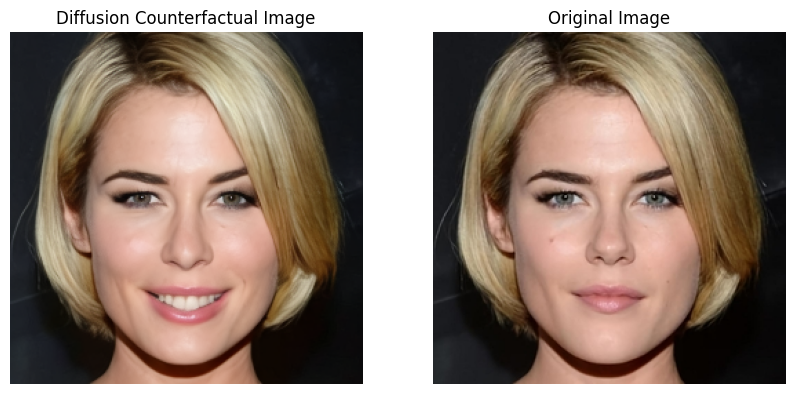

100%|██████████| 2/2 [00:33<00:00, 16.77s/it]

finish


In [1]:
import PIL.Image
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import imageio
import math
import os

from diffusers import UNet2DModel, DDIMScheduler, VQModel
import torch
from torch.utils.data import DataLoader
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from zennit.composites import LayerMapComposite
from zennit.rules import Epsilon, ZPlus, Pass

from data.dataset import ImageDataset, CelebHQAttrDataset
from init_classifier import LinearClassifier, VQVAEClassifier#, VGG16Classifier
from xai_lrp import xai_zennit, show_attributions


class CheckpointedUNetWrapper(torch.nn.Module):
    def __init__(self, model):
        super(CheckpointedUNetWrapper, self).__init__()
        self.model = model

    def checkpointed_forward(self, module, *inputs):
        def custom_forward(*inputs):
            return module(*inputs)
        return checkpoint(custom_forward, *inputs)

    def forward(self, sample, timestep):

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)

        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps * torch.ones(sample.shape[0], dtype=timesteps.dtype, device=timesteps.device)

        t_emb = self.model.time_proj(timesteps)
        #t_emb = t_emb.to(dtype=self.dtype)
        emb = self.model.time_embedding(t_emb)

        # 2. pre-process
        skip_sample = sample
        sample = self.model.conv_in(sample)

        # 3. down
        down_block_res_samples = (sample,)
        for downsample_block in self.model.down_blocks:
            if hasattr(downsample_block, "skip_conv"):
                sample, res_samples, skip_sample = self.checkpointed_forward(downsample_block, sample, emb, skip_sample)
            else:
                sample, res_samples = self.checkpointed_forward(downsample_block, sample, emb)

            down_block_res_samples += res_samples
        
        # 4. mid
        sample = self.checkpointed_forward(self.model.mid_block, sample, emb)

        # 5. up
        skip_sample = None
        for upsample_block in self.model.up_blocks:
            res_samples = down_block_res_samples[-len(upsample_block.resnets) :]
            down_block_res_samples = down_block_res_samples[: -len(upsample_block.resnets)]

            if hasattr(upsample_block, "skip_conv"):
                sample, skip_sample = self.checkpointed_forward(upsample_block, sample, res_samples, emb, skip_sample)
            else:
                sample = self.checkpointed_forward(upsample_block, sample, res_samples, emb)

        # 6. post-process
        sample = self.model.conv_norm_out(sample)
        sample = self.model.conv_act(sample)
        sample = self.model.conv_out(sample)

        if skip_sample is not None:
            sample += skip_sample

        return {"sample": sample}

def classifier_loss(classifier, images, targets, idx):
    preds = classifier(images)
    if idx % 2 == 0:
        print(f"Classifier prediction: {preds[0][31]}")
    targets = torch.tensor(targets).to(device)
    error = torch.nn.functional.binary_cross_entropy_with_logits(preds[0][31], targets)
    preds_binary = torch.sigmoid(preds[0][31]) > 0.5    

    return error, preds_binary

def minDist_loss(images, original_images):
    error = torch.abs(images - original_images).mean()
    return error


# data loading with ground truth no smiling
data = ImageDataset('/home/dai/GPU-Student-2/Cederic/DataSciPro/data/misclsData_gt0', image_size=256, exts=['jpg', 'JPG', 'png'], do_augment=False, sort_names=True)
dataloader = DataLoader(data, batch_size=1, shuffle=False)

# create output folders
directory_names = []
for i, _ in enumerate(dataloader):
    img_index = dataloader.dataset.paths[i].name.split('_')[0]
    directory_name = os.path.join("/home/dai/GPU-Student-2/Cederic/DataSciPro/data_output", f'folder_IMG_{img_index}')
    directory_names.append(directory_name)
    os.makedirs(directory_name, exist_ok=True)
    print(f'Created directory: {directory_name}')

#
device = "cuda" if torch.cuda.is_available() else "cpu"
cls_type = 'linear'

# load all models
unet = UNet2DModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="unet")
vqvae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")
scheduler = DDIMScheduler.from_config("CompVis/ldm-celebahq-256", subfolder="scheduler")

unet.to(device)
vqvae.to(device)

checkpointed_unet = CheckpointedUNetWrapper(unet)

# load all models
if cls_type == 'linear':    
    classifier = LinearClassifier.load_from_checkpoint("/home/dai/GPU-Student-2/Cederic/DataSciPro/cls_checkpoints/ffhq256.b128linear2024-05-31 13:03:42.ckpt",
                                            input_dim = data[0]['img'].shape,
                                            num_classes = len(CelebHQAttrDataset.id_to_cls))
elif cls_type == 'vqvae':
    classifier = VQVAEClassifier.load_from_checkpoint("/home/dai/GPU-Student-2/Cederic/DataSciPro/cls_checkpoints/ffhq256.b32vqvae2024-06-01 08:48:59.ckpt",
                                           num_classes = len(CelebHQAttrDataset.id_to_cls))
    
elif cls_type == 'vgg16':
    classifier = VGG16Classifier.load_from_checkpoint("/home/dai/GPU-Student-2/Cederic/DataSciPro/cls_checkpoints/ffhq256.b32vqvae2024-06-01 08:48:59.ckpt",
                                            num_classes = len(CelebHQAttrDataset.id_to_cls))

classifier.to(device)
classifier.eval()
# check functionality of classifier
all_outputs = []
with torch.no_grad():
    for batch in dataloader:
        inputs = batch['img'].to(classifier.device)
        outputs = classifier(inputs)
        print(outputs[0][31])

        preds_binary = torch.sigmoid(outputs[:, CelebHQAttrDataset.cls_to_id['Smiling']].cpu()) > 0.5
        all_outputs.append(preds_binary) 
all_outputs = torch.cat(all_outputs, dim=0)
print(all_outputs)


###### explainable ai lrp
# lrp rules
layer_map_lrp_0 = [
    (torch.nn.ReLU, Pass()),  # ignore activations
    (torch.nn.Linear, Epsilon(epsilon=0))  # this is the dense Linear, not any Linear
]

layer_map_lrp_zplus = [
    (torch.nn.ReLU, Pass()),
    (torch.nn.Linear, ZPlus())  # this is the dense Linear, not any Linear
]

layer_map_lrp_eps = [
    (torch.nn.ReLU, Pass()),
    (torch.nn.Linear, Epsilon(epsilon=1))  # this is the dense Linear, not any Linear
]

#before manipulation
for i, batch in enumerate(dataloader):
    inputs = batch['img'].to(classifier.device)
    attr_znt_0 = [xai_zennit(classifier, inputs, RuleComposite=LayerMapComposite(layer_map_lrp_eps), device=device, target=torch.tensor(31).to(device))[0]]
    attr_znt_eps = [xai_zennit(classifier, inputs, RuleComposite=LayerMapComposite(layer_map_lrp_0), device=device, target=torch.tensor(31).to(device))[0]]
    attr_znt_zplus = [xai_zennit(classifier, inputs, RuleComposite=LayerMapComposite(layer_map_lrp_zplus), device=device, target=torch.tensor(31).to(device))[0]]
    show_attributions(directory_names[i], attr_znt_0, title='Pre Zennit LRP-0')
    show_attributions(directory_names[i], attr_znt_eps, title='Pre Zennit LRP-EPS')
    show_attributions(directory_names[i], attr_znt_zplus, title='Pre Zennit LRP-Z+')
        
## Inversion
def invert(
    start_latents,
    num_inference_steps,
    device=device,
):

    # Latents are now the specified start latents
    latents = start_latents.clone()

    # We'll keep a list of the inverted latents as the process goes on
    intermediate_latents = []

    # Set num inference steps
    scheduler.set_timesteps(num_inference_steps, device=device)

    # Reversed timesteps <<<<<<<<<<<<<<<<<<<<
    timesteps = reversed(scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), total=num_inference_steps - 1):

        # We'll skip the final iteration
        if i >= num_inference_steps - 1:
            continue

        t = timesteps[i]

        # Expand the latents if we are doing classifier free guidance
        latent_model_input = latents
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual
        noise_pred = checkpointed_unet(latent_model_input, t)["sample"]

        current_t = max(0, t.item() - (1000 // num_inference_steps))  # t
        next_t = t  # min(999, t.item() + (1000//num_inference_steps)) # t+1
        alpha_t = scheduler.alphas_cumprod[current_t]
        alpha_t_next = scheduler.alphas_cumprod[next_t]

        # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
        latents = (latents - (1 - alpha_t).sqrt() * noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (
            1 - alpha_t_next
        ).sqrt() * noise_pred

        # Store
        intermediate_latents.append(latents)

    return torch.cat(intermediate_latents)


class LatentNoise(torch.nn.Module):
    """
    The LatentNoise Module makes it easier to update the noise tensor with torch optimizers.
    """

    def __init__(self, noise: torch.Tensor):
        super().__init__()
        self.noise = torch.nn.Parameter(noise)

    def forward(self):
        return self.noise


def diffusion_pipe(noise_module: LatentNoise, num_inference_steps):
        z = noise_module()
        for i in range(start_step, num_inference_steps):
            t = scheduler.timesteps[i]
            z = scheduler.scale_model_input(z, t)
            with torch.no_grad():
                noise_pred = checkpointed_unet(z, t)["sample"]
            z = scheduler.step(noise_pred, t, z).prev_sample
            z0 = scheduler.step(noise_pred, t, z).pred_original_sample
        return z, z0

def plot_to_pil(tensor):
    image = tensor.cpu().permute(0, 2, 3, 1).clip(-1,1) * 0.5 + 0.5
    image = PIL.Image.fromarray(np.array(image[0].detach().numpy() * 255).astype(np.uint8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def tensor_to_pil_image(tensor):
    image = tensor.cpu().permute(0, 2, 3, 1).clip(-1,1) * 0.5 + 0.5
    image = PIL.Image.fromarray(np.array(image[0].detach().numpy() * 255).astype(np.uint8))
    return image

def normalize(cond):
        mean = torch.mean(input=cond, dim=-1, keepdim=True)
        std = torch.std(input=cond, dim=-1, keepdim=True)

        cond = (cond - mean.to(device)) / std.to(device)
        return cond

def denormalize(cond):
        mean = torch.mean(input=cond, dim=-1, keepdim=True)
        std = torch.std(input=cond, dim=-1, keepdim=True)

        cond = (cond * std.to(device)) + mean.to(device)
        return cond


# conditional sampling
num_inference_steps = 130
start_step = 30


for step, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    #plot_to_pil(batch['img'])
    with torch.no_grad():
        z = vqvae.encode(batch['img'].to(device))   # encode the image in the latent space
    z = z.latents
    
    #cond = z.view(1,-1)
    #cond = normalize(cond)
    #cond = cond + 0.5 * math.sqrt(512) * classifier.fc1.weight[31].unsqueeze(0)
    #cond = denormalize(cond)
    #z = cond.view(1,3,64,64)
    #dec_z = vqvae.decode(z)[0]
    #plot_to_pil(dec_z)
    
    inverted_latents = invert(z, num_inference_steps)                  # do the ddim scheduler reversed to add noise to the latents
    z = inverted_latents[-(start_step + 1)].unsqueeze(0)                  # use these latents to start the sampling. better performance when using not the last latent sample
    noise_module = LatentNoise(z.clone()).to(device)                    # convert latent noise to a parameter module for optimization
    noise_module.noise.requires_grad = True
    intermediate_results = []   # list to store the results of the steering


    """
    with torch.no_grad():
        im = vqvae.decode(inverted_latents[-1].unsqueeze(0))
        im_processed = im[0].cpu().permute(0, 2, 3, 1).clip(-1,1) * 0.5 + 0.5
        im_pil = PIL.Image.fromarray(np.array(im_processed[0] * 255).astype(np.uint8))
        plt.imshow(im_pil)
        plt.axis('off')
        plt.show()
    """
    
    optimizer = torch.optim.Adam(
        noise_module.parameters(), lr=0.01, maximize=False # not minimize gradient ascent
    )
    learning_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
    
    x = torch.zeros_like(z)
    current_loss = float('inf')
    preds_binary = False
    i = 0
    while (current_loss > 0.1) & (preds_binary == False) :
    #for i in tqdm(range(num_optimization_steps)):
            optimizer.zero_grad()
            x, x0 = diffusion_pipe(noise_module, num_inference_steps) # forward
            decoded_x = vqvae.decode(x)[0]

            if i % 1 == 0:
                intermediate_results.append(decoded_x)
                #plot_to_pil(decoded_x)

            loss, preds_binary = classifier_loss(classifier, decoded_x, 1.0, i) #+ minDist_loss(decoded_x, batch['img'].to(device)) * 5
            
            if i % 2 == 0:
                print(i, "loss:", loss.item(), "lr:", learning_scheduler.get_lr())
                #print(i, "loss:", loss.item())
            loss.backward()
            optimizer.step()
            learning_scheduler.step()

            current_loss = loss.item()
            i += 1
    
    with torch.no_grad():
        image = vqvae.decode(x)[0]

    current_pred = classifier(image)[0][31]
    print(f"Diffusion Counterfactual generated with loss: {current_loss} | classifier_prediction: {current_pred} | in {i} optimization steps")
    
    #lrp after manipulation
    attr_znt_0 = [xai_zennit(classifier, image, RuleComposite=LayerMapComposite(layer_map_lrp_eps), device=device, target=torch.tensor(31).to(device))[0]]
    attr_znt_eps = [xai_zennit(classifier, image, RuleComposite=LayerMapComposite(layer_map_lrp_0), device=device, target=torch.tensor(31).to(device))[0]]
    attr_znt_zplus = [xai_zennit(classifier, image, RuleComposite=LayerMapComposite(layer_map_lrp_zplus), device=device, target=torch.tensor(31).to(device))[0]]
    show_attributions(directory_names[step], attr_znt_0, title='Post Zennit LRP-0')
    show_attributions(directory_names[step], attr_znt_eps, title='Post Zennit LRP-EPS')
    show_attributions(directory_names[step], attr_znt_zplus, title='Post Zennit LRP-Z+')
    image.requires_grad = False
    
    images = [tensor_to_pil_image(tensor) for tensor in intermediate_results]
    gif_path = f"{directory_names[step]}/GIF.gif"
    imageio.mimsave(gif_path, images, format='GIF', duration=2.0, loop=0)  # duration is in seconds


    # process image
    image_processed = image.cpu().permute(0, 2, 3, 1).clip(-1,1) * 0.5 + 0.5
    image_pil = PIL.Image.fromarray(np.array(image_processed[0] * 255).astype(np.uint8))
    ori_processed = batch['img'].cpu().permute(0, 2, 3, 1).clip(-1,1) * 0.5 + 0.5
    ori_image = PIL.Image.fromarray(np.array(ori_processed[0] * 255).astype(np.uint8))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image_pil)
    axs[0].axis('off')
    axs[0].set_title('Diffusion Counterfactual Image')
    axs[1].imshow(ori_image)
    axs[1].axis('off')
    axs[1].set_title('Original Image')
    plt.show()
    fig.savefig(f'{directory_names[step]}/ori_vs_DCE.png', dpi=300, bbox_inches='tight')

    image_pil.save(f"{directory_names[step]}/diffCounter_IMG.png")
    print('finish')